# **1. WGRANIE BIBLIOTEK, DANYCH, OCZYSZCZENIE DANYCH**

In [391]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
import folium

In [392]:
plt.rcParams['figure.figsize'] = [12,8]

In [393]:
df_l = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path_name = os.path.join(dirname, filename)
        df_l.append(pd.read_csv(path_name))

df = df_l[0]

In [394]:
df.shape

(21613, 21)

Sprawdzenie typów

In [395]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Pozbycie się kolumn z niepotrzebnymi danymi (id, data).

In [396]:
df = df.drop(['id', 'date'], axis=1)

Sprawdzenie, czy tabela danych zawiera jakieś puste wartości.

In [397]:
df.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Widzę, że dane zostały już uprzednio oczyszczone (odpowiednie typy, brak pustych pól). W związku z tym mogę przejść do analizy danych. Najpierw - macierz z korelacją pomiędzy poszeczególnymi elementami. Wrócę do niej później.

# 2. WIZUALIZACJA DANYCH

Tabela korelacji:

In [398]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1,0.30835,0.525138,0.702035,0.0896609,0.256794,0.266369,0.397293,0.0363618,0.667434,0.605567,0.323816,0.0540115,0.126434,-0.0532029,0.307003,0.0216262,0.585379,0.0824472
bedrooms,0.30835,1,0.515884,0.576671,0.0317032,0.175429,-0.00658248,0.0795319,0.0284721,0.356967,0.4776,0.303093,0.154178,0.0188408,-0.152668,-0.00893101,0.129473,0.391638,0.0292442
bathrooms,0.525138,0.515884,1,0.754665,0.0877397,0.500653,0.0637436,0.187737,-0.124982,0.664983,0.685342,0.28377,0.506019,0.050739,-0.203866,0.024573,0.223042,0.568634,0.0871754
sqft_living,0.702035,0.576671,0.754665,1,0.172826,0.353949,0.103818,0.284611,-0.0587526,0.762704,0.876597,0.435043,0.318049,0.0553629,-0.19943,0.0525295,0.240223,0.75642,0.183286
sqft_lot,0.0896609,0.0317032,0.0877397,0.172826,1,-0.00520099,0.0216037,0.0747101,-0.00895825,0.113621,0.183512,0.0152862,0.0530804,0.00764351,-0.129574,-0.0856828,0.229521,0.144608,0.718557
floors,0.256794,0.175429,0.500653,0.353949,-0.00520099,1,0.0236983,0.0294438,-0.263768,0.458183,0.523885,-0.245705,0.489319,0.0063384,-0.0591206,0.0496141,0.125419,0.279885,-0.0112692
waterfront,0.266369,-0.00658248,0.0637436,0.103818,0.0216037,0.0236983,1,0.401857,0.0166532,0.0827749,0.0720746,0.0805879,-0.0261611,0.0928848,0.0302847,-0.0142738,-0.0419102,0.0864631,0.0307033
view,0.397293,0.0795319,0.187737,0.284611,0.0747101,0.0294438,0.401857,1,0.0459897,0.251321,0.167649,0.276947,-0.0534399,0.103917,0.0848269,0.00615673,-0.0783997,0.280439,0.0725746
condition,0.0363618,0.0284721,-0.124982,-0.0587526,-0.00895825,-0.263768,0.0166532,0.0459897,1,-0.144674,-0.158214,0.174105,-0.361417,-0.0606178,0.00302552,-0.014941,-0.1065,-0.0928243,-0.00340552
grade,0.667434,0.356967,0.664983,0.762704,0.113621,0.458183,0.0827749,0.251321,-0.144674,1,0.755923,0.168392,0.446963,0.0144143,-0.184862,0.114084,0.198372,0.713202,0.119248


#### Zwizualizuję teraz dane, które mają wyraźną korelację z ceną.

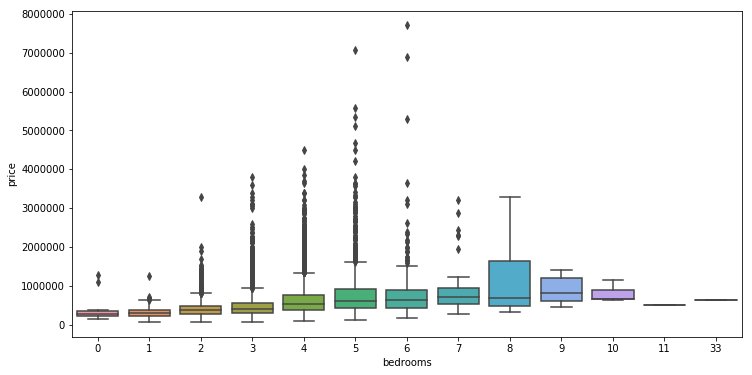

In [399]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='bedrooms', y='price', data=df)
plt.show()

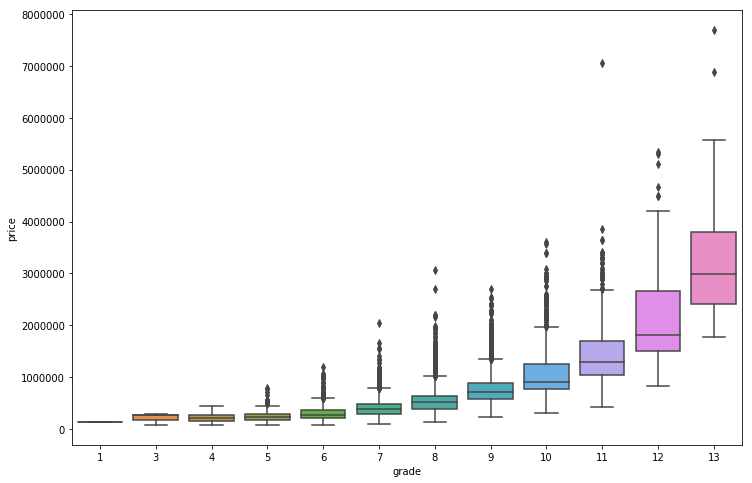

In [400]:
sns.boxplot(x='grade', y='price', data=df)
plt.show()

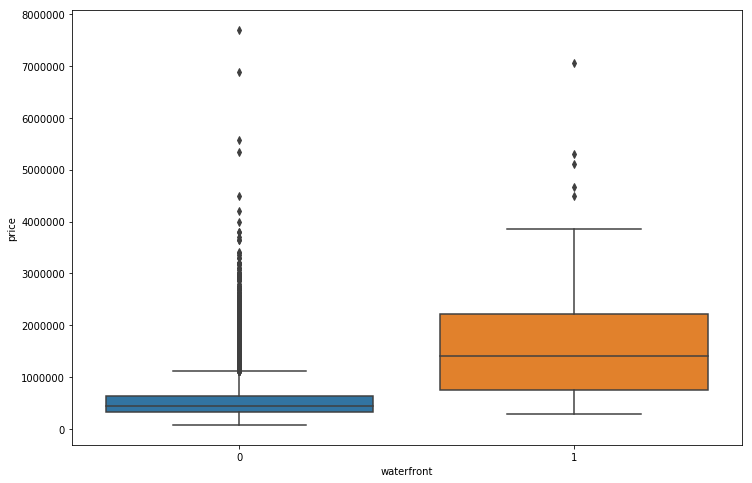

In [401]:
sns.boxplot(x='waterfront', y='price', data=df)
plt.show()

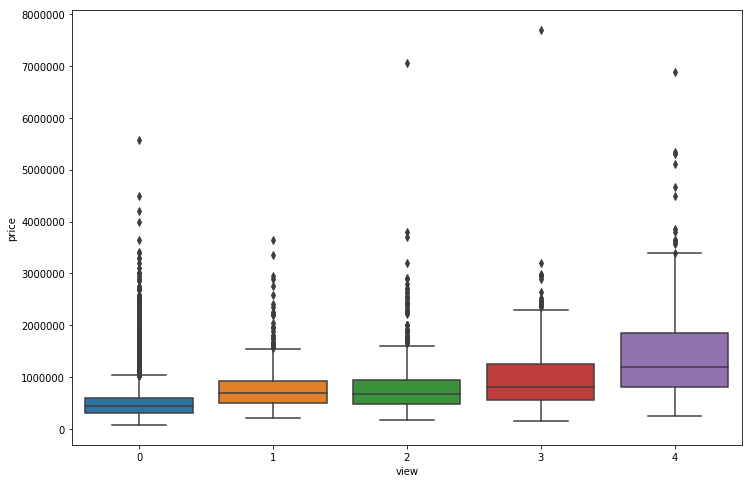

In [402]:
sns.boxplot(x='view', y='price', data=df)
plt.show()

Jest też oczywista korelacja pomiędzy sumą powierzchni budynku a ceną. Ta relacja jest mniej więcej liniowa. Oczywiście, zwykła prosta oparta na samej cenie nie będzie dobrym przybliżeniem ceny.

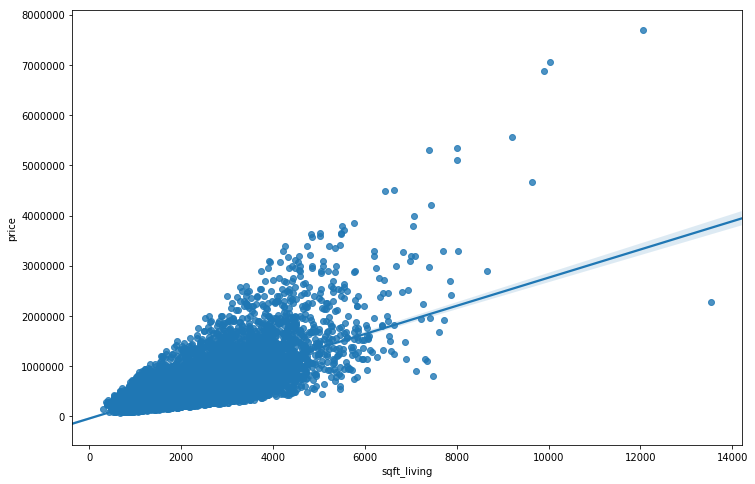

In [403]:
sns.regplot(x='sqft_living', y='price', data=df)

### Chcę też wizualnie przedstawić korelację między szerokością geograficzną a ceną (Z macierzy korelacji wynika, że istnieje wyraźny związek).

Najpierw podzielę dane na 3 równe części ze względu na cenę - domy tanie (1), średnie(2) i drogie(3):

In [404]:
labels = [1, 2, 3]
df['binned_price'] = pd.qcut(df['price'], q=3, labels=labels)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,binned_price
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,1
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,1
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,3
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2


Poniższa mapa przedstawia wizualnie cenę domów (zielony - niska, niebieski - średnia, czerwony - wysoka). Bardzo wyraźnie widać przewagę zielonych punktów na południu i czerwonych na północy (co wyjaśnia korelację 0.3 z macierzy). Mapa wizualizuje 1000 losowo wybranych pozycji (jako że wizualizacja wszystkich jest zbyt kosztowna obliczeniowo, a wizualizacja pierwszych 1000 mogłaby być niereprezentatywna). Odświeżenie kodu powoduje zmianę losowanych danych.

In [405]:
map_df = df.sample(1000, axis=0)
data_mean_lat = map_df['lat'].mean()
data_mean_lon = map_df['long'].mean()
colors = {1: 'green', 2: 'blue', 3: 'red'}
king_county = folium.Map(location=[data_mean_lat, data_mean_lon], zoom_start=10)

# Add markers to map
for lat, long, price, price_bin in zip(map_df['lat'], map_df['long'], map_df['price'], map_df['binned_price']):
    label = f'{price}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color=colors[price_bin],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(king_county)  
    
king_county

Widać dosyć wyraźną korelację pomiędzy wysokością geograficzną a ceną - domy na południu znajdują się zdecydowanie częściej w grupie z niskimi cenami.

# 3. BUDOWANIE MODELI PREDYKCYJNYCH

Zacznę od wyboru wartości na których będę opierał moje przewidywania. Majpierw wrócę do macierzy korelajci.

In [406]:
correlated_features = df.corr()['price'].sort_values()
correlated_features

zipcode         -0.053203
long             0.021626
condition        0.036362
yr_built         0.054012
sqft_lot15       0.082447
sqft_lot         0.089661
yr_renovated     0.126434
floors           0.256794
waterfront       0.266369
lat              0.307003
bedrooms         0.308350
sqft_basement    0.323816
view             0.397293
bathrooms        0.525138
sqft_living15    0.585379
sqft_above       0.605567
grade            0.667434
sqft_living      0.702035
price            1.000000
Name: price, dtype: float64

Wybór tylko tych cech, których korelacja z ceną jest większa od 0.1 albo mniejsza od -0.1:

In [407]:
features = []
for fname, feat in zip(correlated_features.index, correlated_features):
    if abs(feat) > 0.1 and fname != 'price':
        features.append(fname)
features

['yr_renovated',
 'floors',
 'waterfront',
 'lat',
 'bedrooms',
 'sqft_basement',
 'view',
 'bathrooms',
 'sqft_living15',
 'sqft_above',
 'grade',
 'sqft_living']

In [408]:
X_data = df[features]
y_data = df['price']
X_data.head()

,yr_renovated,floors,waterfront,lat,bedrooms,sqft_basement,view,bathrooms,sqft_living15,sqft_above,grade,sqft_living
0,0,1.0,0,47.5112,3,0,0,1.00,1340,1180,7,1180
1,1991,2.0,0,47.7210,3,400,0,2.25,1690,2170,7,2570
2,0,1.0,0,47.7379,2,0,0,1.00,2720,770,6,770
3,0,1.0,0,47.5208,4,910,0,3.00,1360,1050,7,1960
4,0,1.0,0,47.6168,3,0,0,2.00,1800,1680,8,1680


Podzielenie danych na treningowe i testowe. Normalizacja danych.

In [409]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1)
X_train_ns, X_test_ns = X_train, X_test
X_train, X_test = preprocessing.scale(X_train), preprocessing.scale(X_test)
y_train, y_test = y_train/10000, y_test/10000
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_data_norm, y_data, test_size=0.3)

## 1. Regresja liniowa:

In [410]:
lr = LinearRegression().fit(X_train, y_train)
print(f'Results for linear regression:\nTrain score: {lr.score(X_train, y_train)}, test score: {lr.score(X_test, y_test)}')
yhat = lr.predict(X_test)
print(f'Mean squared error: {mean_squared_error(yhat, y_test)}')

Results for linear regression:
Train score: 0.6653647063991707, test score: 0.6439590618169333
Mean squared error: 614.5301167046947


Jak widać, zwykła regresja liniowa jest średmim modelem, niemniej będę traktował wynik 65% jako wartość wyjściową.

## 2. Drzewo regresyjne:

In [411]:
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)
print(f'Regression tree score on:\nTrain data: {regressor.score(X_train, y_train)}\nTest data:{regressor.score(X_test, y_test)}')

Regression tree score on:
Train data: 0.9992555977944052
Test data:0.6866590127673703


Z faktu 100% celności w przewidywaniu danych treningowych i słabej celności z danymi testowymi wynika to, że model jest nadmiernie dopasowany. Postaram się to zmienić tak, żeby wyniki na danych testowych i treningowych były podobne. Żeby zmiejszyć dopasowanie danych do modelu treningowego zmodyfikuję parametry min_samples_leaf, max_leaf_nodes i max_depth. Wybiorę najlepszy wynik iterując przez kilkaset drzew ze zmienionymi parametrami.

In [412]:
score = 0
for leaf_sample in range(3, 10):
    for depth in range(6, 12):
        for leaf_node in range(19, 29):
            regressor = DecisionTreeRegressor(random_state = 0, min_samples_leaf=leaf_sample, max_leaf_nodes=leaf_node *10, max_depth=depth)
            regressor.fit(X_train, y_train)
            temp_score = regressor.score(X_test, y_test)
            if temp_score > score:
                score = temp_score
                best_regressor = regressor
                best_param = {'min_samples_leaf': leaf_sample, 'max_depth': depth, 'max_leaf_nodes': leaf_node * 10}
yhat = best_regressor.predict(X_test)
print(f'Regression tree score on:\nTrain data: {best_regressor.score(X_train, y_train)}\nTest data:{best_regressor.score(X_test, y_test)}\nParameters of the tree:{best_param}')
print(f'Mean squared error: {mean_squared_error(yhat, y_test)}')

Regression tree score on:
Train data: 0.8464768795489931
Test data:0.7624225669485012
Parameters of the tree:{'min_samples_leaf': 6, 'max_depth': 11, 'max_leaf_nodes': 280}
Mean squared error: 410.06095648605105


Celność drzewa wzrosła do 76%, a wyniki dla danych testowych i treningowych są bardziej zbliżone. Zapiszę schemat drzewa do pliku .dot.

In [413]:
from sklearn.tree import export_graphviz  
  
export_graphviz(regressor, out_file ='tree.dot', 
               feature_names=features) 

## 3. Regresja liniowa z dopasowaniem wielomianowym stopnia 2:

In [414]:
pipe_input = [('scale',StandardScaler()),('polynomial', PolynomialFeatures(degree = 2,include_bias=False)),('model',LinearRegression())]
pipe = Pipeline(pipe_input)
pipe.fit(X_train_ns, y_train)
yhat = pipe.predict(X_test_ns)
print(f'Results for linear regression with polynomial fit of degree 2:\nTrain score: {pipe.score(X_train_ns, y_train)}, test score: {pipe.score(X_test_ns, y_test)}')
print(f'Mean squared error: {mean_squared_error(yhat, y_test)}')

Results for linear regression with polynomial fit of degree 2:
Train score: 0.7519083894211767, test score: 0.7735177993511398
Mean squared error: 390.910477616811


## 4. Model regresyjny sieci neuronowej.

In [415]:
ml_regressor = MLPRegressor()
ml_regressor.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [416]:
ml_regressor.score(X_test, y_test)
yhat = ml_regressor.predict(X_test) 
print(f'Results for neural network model:\nTrain score: {ml_regressor.score(X_train, y_train)}, test score: {ml_regressor.score(X_test, y_test)}')
print(f'Mean squared error: {mean_squared_error(y_test, yhat)}')

Results for neural network model:
Train score: 0.8223953819068639, test score: 0.8062887890860899
Mean squared error: 334.34743110559106


## 5. Model regresyjny sieci neuronowej (Keras):

Dla zrobienia drugiego, lepszego modelu potanowiłem użyć biblioteki Kerasa. Daje mi lepszą kontrolę nad modelem.

In [417]:
n_cols = X_test.shape[1]
n_cols

12

In [418]:
def regression_model(n_cols):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Stworzenie modelu

In [425]:
k_model = regression_model(n_cols)

Trenowanie modelu. Powinno zająć koło 10 minut.

In [426]:
for _ in range(8):
    k_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, verbose=2, validation_split=0.1)

Train on 17290 samples, validate on 4323 samples
Epoch 1/25
 - 3s - loss: 1092.3030 - val_loss: 567.7671
Epoch 2/25
 - 2s - loss: 410.0638 - val_loss: 537.9176
Epoch 3/25
 - 2s - loss: 386.7921 - val_loss: 519.1302
Epoch 4/25
 - 2s - loss: 376.6315 - val_loss: 504.8237
Epoch 5/25
 - 2s - loss: 364.6921 - val_loss: 526.7378
Epoch 6/25
 - 2s - loss: 355.5077 - val_loss: 492.4814
Epoch 7/25
 - 2s - loss: 348.6861 - val_loss: 523.5291
Epoch 8/25
 - 2s - loss: 341.8952 - val_loss: 491.5558
Epoch 9/25
 - 2s - loss: 333.6666 - val_loss: 455.5566
Epoch 10/25
 - 2s - loss: 314.5000 - val_loss: 424.4600
Epoch 11/25
 - 2s - loss: 293.2096 - val_loss: 410.2702
Epoch 12/25
 - 2s - loss: 274.4658 - val_loss: 427.1469
Epoch 13/25
 - 2s - loss: 264.0971 - val_loss: 372.8085
Epoch 14/25
 - 2s - loss: 256.7114 - val_loss: 404.7038
Epoch 15/25
 - 2s - loss: 250.0149 - val_loss: 360.6936
Epoch 16/25
 - 2s - loss: 249.0919 - val_loss: 361.3936
Epoch 17/25
 - 2s - loss: 245.9089 - val_loss: 370.8505
Epoch 1

Epoch 18/25
 - 1s - loss: 182.1234 - val_loss: 297.5859
Epoch 19/25
 - 1s - loss: 182.4163 - val_loss: 318.5156
Epoch 20/25
 - 1s - loss: 182.3953 - val_loss: 309.9545
Epoch 21/25
 - 1s - loss: 182.1463 - val_loss: 314.2839
Epoch 22/25
 - 1s - loss: 181.4983 - val_loss: 297.5546
Epoch 23/25
 - 1s - loss: 181.8081 - val_loss: 306.3908
Epoch 24/25
 - 1s - loss: 181.0058 - val_loss: 297.9052
Epoch 25/25
 - 1s - loss: 181.2874 - val_loss: 303.8245
Train on 17290 samples, validate on 4323 samples
Epoch 1/25
 - 1s - loss: 181.4215 - val_loss: 309.2354
Epoch 2/25
 - 1s - loss: 181.1572 - val_loss: 306.5186
Epoch 3/25
 - 1s - loss: 181.3338 - val_loss: 311.8585
Epoch 4/25
 - 1s - loss: 180.5852 - val_loss: 304.3530
Epoch 5/25
 - 1s - loss: 178.9521 - val_loss: 321.5209
Epoch 6/25
 - 1s - loss: 181.6520 - val_loss: 294.3162
Epoch 7/25
 - 2s - loss: 180.2074 - val_loss: 309.7947
Epoch 8/25
 - 1s - loss: 180.4408 - val_loss: 303.4588
Epoch 9/25
 - 2s - loss: 180.2942 - val_loss: 307.8728
Epoch 10

Zapisanie modelu:

In [427]:
score = k_model.evaluate(X_test, y_test)
print(f'Mean squared error: {score}')

4323/4323 [==============================] - 0s 65us/step
Mean squared error: 305.58935721946926


Jak widać model ma około 10% mniejszy błąd w porównaniu do poprzedniego modelu (305 do 334). Zapiszę go teraz, żeby nie musieć powtarzać procesu trenowania za każdym razem.

In [428]:
k_model.save('regression_model.h5')